# Tutorial5: 大模型微调

本节旨在使用 Hugging Face 官方发布的 bert-base-uncased 模型展示大模型微调的过程。

分以下几步来实现：
1. 环境安装
2. 加载模型和数据
3. 模型微调

## 1. 环境安装

我们默认用户已经按照 [tutorial_scow_for_ai](../tutorial_scow_for_ai.md) 在 “交互式应用” 中创建了  Jupyter Lab 应用，并已经安装了 conda。现在需要在命令行中创建环境并注册 ipykernal：

```bash
conda create --name finetune python=3.9
conda activate finetune
# 安装内核
conda install ipykernel
# 注册内核
python -m ipykernel install --user --name=finetune --display-name="finetune"
conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
pip install datasets evaluate scipy scikit-learn transformers
```

（ pytorch 版本需与 cuda 版本对应，请查看版本对应网站：https://pytorch.org/get-started/previous-versions ，通过 nvidia-smi 命令可查看 cuda 版本）

打开本 .ipynb 文件并选择 kernel 为 finetune。硬件资源建议使用1张GPU运行。

CUDA Version: 12.1; Torch Version: 2.3.1

## 2. 加载模型和数据

可以自行上传模型和数据，也可以通过网络下载，在下面的代码中，程序会自动检查模型和数据文件是否存在，如果不存在则会通过网络下载。

## 2.1 上传模型和数据

可以在“文件管理”里上传：

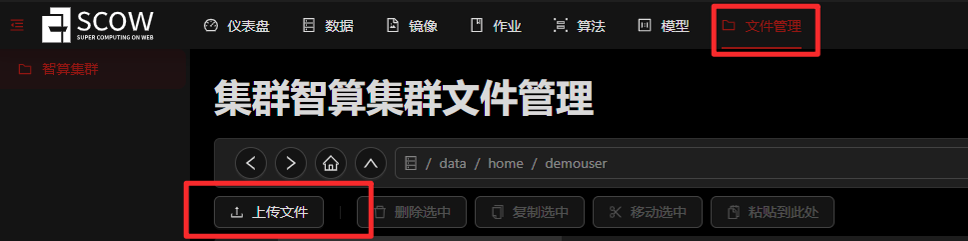

也可以在 jupyter lab 中上传：

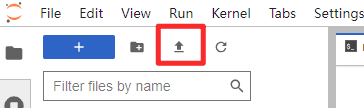

使用的数据为 MRPC（Microsoft Research Paraphrase Corpus），该数据集包含 5,801 对句子，并带有标签，表明两个句子的意思是否相同。

## 2.2 下载模型和数据

也可以通过网络下载模型和数据，如果不能直接获取数据则需要在命令行中执行

```bash
export HF_ENDPOINT=https://hf-mirror.com
python -c "from datasets import load_dataset; raw_datasets = load_dataset('glue', 'mrpc')"
python -c "from transformers import AutoTokenizer; tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')"
python -c "from transformers import AutoModelForSequenceClassification; model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)"
```

In [ ]:
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import AutoTokenizer
import os

# 模型和数据路径
model_path = "model"
data_path = "data"

# 加载模型（直接读取或从网络下载）
if os.path.exists(model_path) and os.path.isdir(model_path):
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
else: 
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# 加载数据
if os.path.exists(data_path) and os.path.isdir(data_path):
    raw_datasets = load_dataset(data_path)
else:
    raw_datasets = load_dataset("glue", "mrpc")
    
# 分词，使用 .map 方法为数据集添加 token 相关的 key
def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# 数据处理，去除不相关的 key，重命名 label key
tokenized_datasets = tokenized_datasets.remove_columns(["sentence1", "sentence2", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

## 3. 模型微调

我们这里使用的是一张 NVIDIA GeForce RTX 3090 24G 显卡进行微调。本节参考资料：[[链接]](https://huggingface.co/learn/nlp-course/chapter3/4?fw=pt)

微调过程中使用 nvidia-smi 命令可以查看 GPU 运行情况。

由于网络问题，需要先在命令行中执行以下命令：

```bash
export HF_ENDPOINT=https://hf-mirror.com # 设置代理，如果可以直接访问则不需要设置代理
python -c "import evaluate; metric = evaluate.load('glue', 'mrpc'); print(metric)"
```

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW, get_scheduler, DataCollatorWithPadding
import torch
import torch_npu
from tqdm.auto import tqdm
import os
import evaluate
import numpy as np


# 指定 batch_size
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # 按照 batch 中最大的长度自动填充 padding
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

# 硬件
device = torch.device("npu:0") if torch.npu.is_available() else torch.device("cpu")
model.to(device)

# 训练参数
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# 评估函数
metric = evaluate.load("glue", "mrpc")
def compute_eval(model, eval_dataloader, device, metric=metric):
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            metric.add_batch(predictions=predictions, references=batch["labels"])
    
    eval_result = metric.compute()
    
    return eval_result

# 训练过程
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    for batch_idx, batch in enumerate(train_dataloader):
    
        # 前向传播
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        
        # 更新参数
        optimizer.step()
        lr_scheduler.step()
        
        progress_bar.update(1)
        
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}")
    
    print(f"Epoch {epoch}: eval metric --> {compute_eval(model, eval_dataloader, device)}")

In [ ]:
# 保存模型
model.save_pretrained('model_trained')

---

> 作者: 黎颖; 龙汀汀
>
> 联系方式: yingliclaire@pku.edu.cn;   l.tingting@pku.edu.cn